In [21]:
# First line of imports 
from sklearn.datasets import load_files
from keras.utils import np_utils
import pandas as pd
import numpy as np
import keras
from glob import glob
from tqdm import tqdm

# define a function that takes in image path and return input and target data
def load_dataset(path):
    data = load_files(path)
    my_files = np.array(data['filenames'])  # these ['filenames'] and ['targets'] are specific extractions for load_files function
    my_targets = np_utils.to_categorical(np.array(data['target']), num_classes =  2)
    return my_files, my_targets

# load path files to training, validation and testing sets 
x_train, y_train = tqdm(load_dataset('data/train'))
x_test, y_test = load_dataset('data/test')
x_val, y_val = load_dataset('data/valid')

# Check if X and y (inputs and targets) have the same length
assert len(x_train) == len(y_train)
assert len(x_test) == len(y_test)
assert len(x_val) == len(y_val)

# print the number of each set 
print('training set has ---> {} pictures'.format(len(x_train)))
print('testing set has ---> {} pictures'.format(len(x_test)))
print('validation set has ---> {} pictures'.format(len(x_val)))


100%|██████████| 2/2 [00:00<00:00, 981.93it/s]


training set has ---> 2000 pictures
testing set has ---> 600 pictures
validation set has ---> 150 pictures


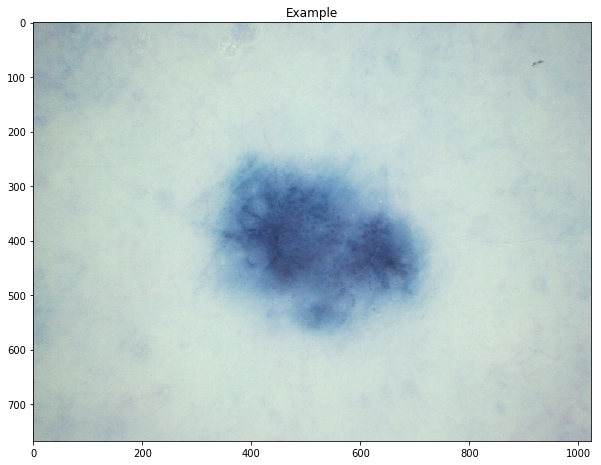

In [22]:

import matplotlib.pyplot as plt
%matplotlib inline
import cv2

# check example of a picture
plt.figure(figsize = (10,10))
img = cv2.imread(x_train[2])
plt.imshow(img)
plt.title('Example')
plt.show()


In [23]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img                  


def image_path_to_a_tensor(img_path):
    
    # load rbg ad pil
    img = load_img(img_path, target_size = (224,224))
    # convert into matrix with shape of (224,224,3)
    img = img_to_array(img)
    # increase 3d shape to 4d shape ( from 224, 224, 3    to 1,224,224,3)
    return np.expand_dims(img, axis= 0)
    

def paths_to_tensor(img_paths):
    list_of_tensors = [image_path_to_a_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True

# rescale data
x_train = paths_to_tensor(x_train).astype('float32')/255
x_test = paths_to_tensor(x_test).astype('float32')/255
x_val = paths_to_tensor(x_val).astype('float32')/255

# Check sizes of different types of skin conditions for even'ish distribution

for x in [y_train, y_val, y_test]:
    
    cat1 = 0
    cat2 = 0
    #cat3 = 0   

    for i in [0,1]:
        
        for j in range(len(x)):
            
            if (x[j][i] != 0 and i == 0):
                cat1 += 1
            elif (x[j][i] != 0 and i == 1):
                cat2 += 1
            #elif (x[j][i] != 0 and i == 2):
            #   cat3 += 1
                
    print('For x the distribution of targets are as follows:')
    print('Category1 : {}, Category2 : {}'.format(cat1/len(x), cat2/len(x)))

100%|██████████| 150/150 [00:48<00:00,  3.12it/s]


For x the distribution of targets are as follows:
Category1 : 0, Category2 : 0
For x the distribution of targets are as follows:
Category1 : 0, Category2 : 0
For x the distribution of targets are as follows:
Category1 : 0, Category2 : 0


In [24]:


# Building the architecture
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Dense, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from sklearn.metrics import confusion_matrix

model = Sequential()

#First convolutional layer
model.add(Conv2D(32,kernel_size = (3,3), padding = 'same', input_shape = (224,224,3)))
model.add(LeakyReLU(alpha= 0.25))
model.add(BatchNormalization())

#First pooling layer
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

#add second convolutional layer
model.add(Conv2D(64, kernel_size = (3,3), padding ='same'))
model.add(LeakyReLU(alpha = 0.25))
model.add(BatchNormalization())

#add secodn pooling layer
model.add(MaxPooling2D(pool_size = 2, padding = 'same'))

# add third convolutional layer
model.add(Conv2D(filters = 128, kernel_size = 2, padding = 'same'))
model.add(LeakyReLU(alpha = 0.25))   
model.add(BatchNormalization())

# add GAP layer
model.add(GlobalAveragePooling2D())



# add a fully connected dense layer
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.5))

# add final layer
model.add(Dense(2, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 112, 112, 64)      256       
__________

In [25]:
from sklearn.metrics import f1_score
def evaluate(expected_out, predicted_out):
    expected_categories = [np.argmax(x) for x in expected_out]
    predicted_categories = [np.argmax(x) for x in predicted_out]
    cm = confusion_matrix(expected_categories, predicted_categories)
    print(cm)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_stuff/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)


model.fit(x_train,y_train, batch_size = 20, epochs = 20, verbose = 0, callbacks  = [checkpointer], validation_data = (x_val, y_val))

model.load_weights('saved_stuff/weights.best.from_scratch.hdf5')

predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis = 0))) for tensor in x_test]

#reporting  test set accuracy
t_acc = 100*np.sum(np.array(predictions) == np.argmax(y_test, axis = 1))//len(predictions)
print('Test accucary : {}%'.format(t_acc))




Epoch 00001: val_loss improved from inf to 0.49726, saving model to saved_stuff/weights.best.from_scratch.hdf5

Epoch 00002: val_loss did not improve

Epoch 00003: val_loss improved from 0.49726 to 0.48976, saving model to saved_stuff/weights.best.from_scratch.hdf5

Epoch 00004: val_loss did not improve

Epoch 00005: val_loss did not improve

Epoch 00006: val_loss did not improve

Epoch 00007: val_loss did not improve

Epoch 00008: val_loss did not improve

Epoch 00009: val_loss improved from 0.48976 to 0.46229, saving model to saved_stuff/weights.best.from_scratch.hdf5

Epoch 00010: val_loss did not improve

Epoch 00011: val_loss did not improve

Epoch 00012: val_loss did not improve

Epoch 00013: val_loss did not improve

Epoch 00014: val_loss did not improve

Epoch 00015: val_loss did not improve

Epoch 00016: val_loss did not improve

Epoch 00017: val_loss did not improve

Epoch 00018: val_loss did not improve

Epoch 00019: val_loss did not improve

Epoch 00020: val_loss did not i

In [26]:
valid_predicted_out = model.predict(x=x_val, batch_size=20)
evaluate(y_val, valid_predicted_out)

[[ 13  17]
 [ 10 110]]
